In [15]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
# import open3d as o3d
import matplotlib.pyplot as plt

from core import *

from utils import geometry

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [16]:
test_phantom = phantom.Phantom(
            voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
            matrix_dims = (128,128,64),
            baseline = (1540, 1000),
            seed = 5678,)

water = tissue.Tissue(name='water', c=1540, rho=1000, sigma=0, scale=0.0001, label=0)
t1 = tissue.Tissue(name='t1', c=1540, rho=1000, sigma=0, scale=0.0001, label=1)
t2 = tissue.Tissue(name='t2', c=1540, rho=1000, sigma=15, scale=0.0001, label=2)
t3 = tissue.Tissue(name='t3', c=1540, rho=1000, sigma=30, scale=0.0001, label=3)
t4 = tissue.Tissue(name='t4', c=1540, rho=1000, sigma=45, scale=0.0001, label=4)
t5 = tissue.Tissue(name='t5', c=1540, rho=1000, sigma=60, scale=0.0001, label=5)

pos = 0.008
test_phantom.add_tissue(water, mask=np.ones(test_phantom.matrix_dims))

test_phantom.add_tissue_sphere((0,-2*pos,0), 4, t1)
test_phantom.add_tissue_sphere((0,-pos,0), 4, t2)
test_phantom.add_tissue_sphere((0,0,0), 4, t3)
test_phantom.add_tissue_sphere((0,pos,0), 4, t4)
test_phantom.add_tissue_sphere((0,2*pos,0), 4, t5)
test_phantom.add_tissue_sphere((2*pos,-2*pos,0), 4, t5)
test_phantom.add_tissue_sphere((2*pos,-pos,0), 4, t4)
test_phantom.add_tissue_sphere((2*pos,0,0), 4, t3)
test_phantom.add_tissue_sphere((2*pos,pos,0), 4, t2)
test_phantom.add_tissue_sphere((2*pos,2*pos,0), 4, t1)
    
test_phantom.set_default_tissue('water')
test = test_phantom.get_complete()

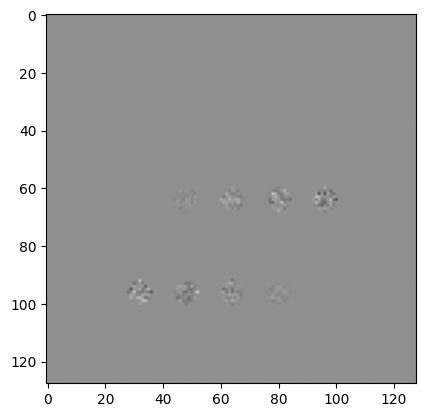

In [17]:
index = 32
plt.imshow(test_phantom.get_complete()[0, :, :, index], cmap='gray', vmin=1400, vmax=1650)

In [18]:
num_transducers = 1

transducers = [transducer.Focused(max_frequency = 0.5e6,
                                  elements = 128, 
                                  width = 20e-3,
                                  height =  20e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = np.pi/2,
                                  ray_num = 64,
                                  imaging_ndims = 2,
                                  focus_azimuth = 80-3,
                                  focus_elevation = 100-3) for i in range(num_transducers)]


for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

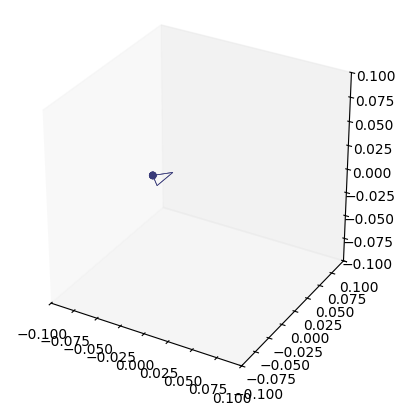

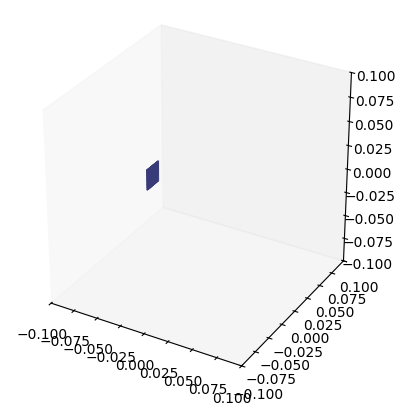

In [19]:
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
test_transducer_set.assign_pose(0, geometry.Transform([0,0,0], [-0.05,0,0]))

test_transducer_set.plot_transducer_fovs(scale=0.1)
test_transducer_set.plot_transducer_coords(scale=0.1)

In [20]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

In [21]:
simprops = simulation.SimProperties(
                grid_size   = (80e-3,40e-3,40e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                grid_lambda = 2,               # 
                )

In [22]:
test_experiment = experiment.Experiment(
                 simulation_path = 'intro_demo',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

test_experiment.save()

In [24]:
test_experiment = experiment.Experiment.load('intro_demo')
test_experiment.run(dry=False, repeat=True) # dry = True will load the data from a previously saved simulation instead of running a new one

running with 3 workers



preparation for sim    0 completed in  0.61 seconds
preparation for sim    1 completed in  0.62 seconds
simulation             0 completed in  1.24 seconds
preparation for sim    2 completed in  0.60 seconds
preparation for sim    3 completed in  0.68 seconds
simulation             1 completed in  1.33 seconds
simulation             2 completed in  1.17 seconds
simulation             3 completed in  1.16 seconds
preparation for sim   32 completed in  0.64 seconds
preparation for sim   33 completed in  0.64 seconds
preparation for sim   34 completed in  0.64 seconds
simulation            32 completed in  1.18 seconds
preparation for sim    4 completed in  0.58 seconds
simulation            33 completed in  1.21 seconds
simulation            34 completed in  1.18 seconds
simulation             4 completed in  1.17 seconds
preparation for sim   35 completed in  0.59 seconds
preparation for sim   36 completed in  0.64 seconds
preparation for sim    5 completed in  0.58 seconds
preparation 

In [25]:
test_experiment.run(dry=True)

dry run of simulation


100%|██████████| 1/1 [00:00<00:00, 42.35it/s]


In [26]:
test_experiment.add_results()

In [27]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)

In [28]:
signals = test_reconstruction.get_signals(dimensions=2, matsize=1024, downsample=1, workers=16, tgc=5)

100%|██████████| 64/64 [00:02<00:00, 28.28it/s]
1it [00:00,  1.73it/s]


[]

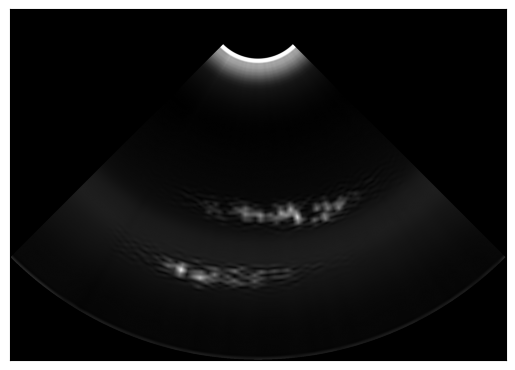

In [29]:
plt.imshow(signals[0], vmax=20000, cmap='gray')
plt.gca().set_facecolor('black')
plt.gca().set_xticks([])
plt.gca().set_yticks([])